=== PROJEKT SZTUCZNE SIECI NEURONOWE ===
Analiza danych szpitalnych
Ładowanie i przygotowanie danych...
Rozmiar danych: (318438, 18)
Kolumny: ['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Hospital_region_code', 'Available Extra Rooms in Hospital', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade', 'patientid', 'City_Code_Patient', 'Type of Admission', 'Severity of Illness', 'Visitors with Patient', 'Age', 'Admission_Deposit', 'Stay']
Liczba kolumn po przetworzeniu: 16

PROBLEM REGRESYJNY - Przewidywanie Admission_Deposit
Liczba cech: 15, Liczba próbek: 318438

Testowanie parametru: hidden_layers
  Testowanie hidden_layers = [5]
  Testowanie hidden_layers = [10]
  Testowanie hidden_layers = [20]
  Testowanie hidden_layers = [30]

Testowanie parametru: activation
  Testowanie activation = sigmoid
  Testowanie activation = relu
  Testowanie activation = tanh
  Testowanie activation = leaky_relu

Testowanie parametru: learning_rate
  Testowanie learni

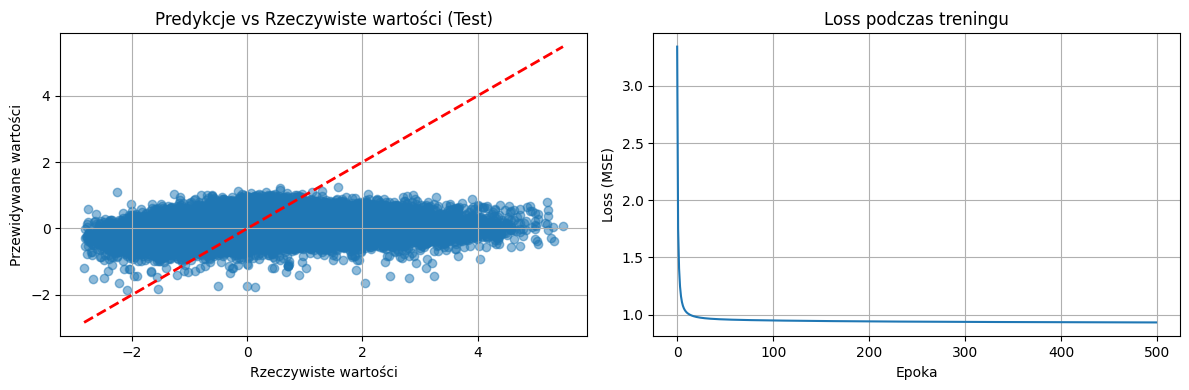


Wizualizacja najlepszego modelu klasyfikacyjnego:

Trenowanie najlepszego modelu z parametrami: {'hidden_layers': [20], 'activation': 'relu', 'learning_rate': 0.2, 'epochs': 1000}
Epoch 0, Loss: 2.1183, Accuracy: 0.2425
Epoch 100, Loss: 1.3713, Accuracy: 0.4189
Epoch 200, Loss: 1.3422, Accuracy: 0.4333
Epoch 300, Loss: 1.3306, Accuracy: 0.4383
Epoch 400, Loss: 1.3242, Accuracy: 0.4413
Epoch 500, Loss: 1.3201, Accuracy: 0.4434
Epoch 600, Loss: 1.3172, Accuracy: 0.4444
Epoch 700, Loss: 1.3150, Accuracy: 0.4456
Epoch 800, Loss: 1.3132, Accuracy: 0.4466
Epoch 900, Loss: 1.3116, Accuracy: 0.4476

Wyniki najlepszego modelu:
Accuracy na zbiorze treningowym: 0.4482
Accuracy na zbiorze testowym: 0.4479


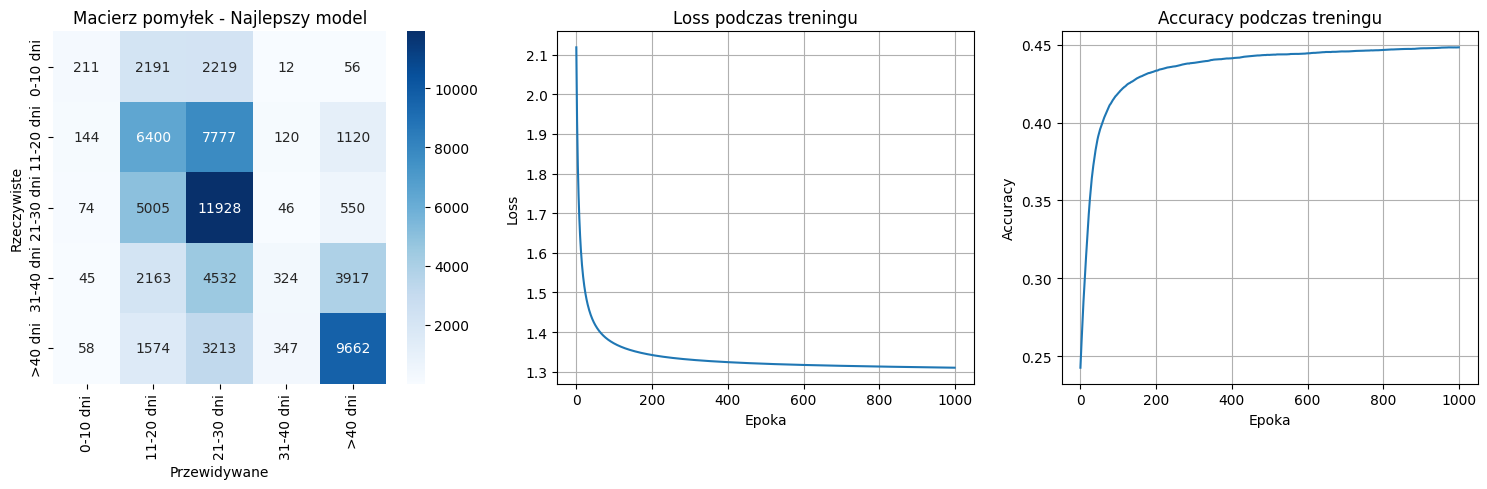


Raport klasyfikacji:
              precision    recall  f1-score   support

    0-10 dni       0.40      0.04      0.08      4689
   11-20 dni       0.37      0.41      0.39     15561
   21-30 dni       0.40      0.68      0.50     17603
   31-40 dni       0.38      0.03      0.05     10981
     >40 dni       0.63      0.65      0.64     14854

    accuracy                           0.45     63688
   macro avg       0.44      0.36      0.33     63688
weighted avg       0.44      0.45      0.40     63688


OGÓLNE WNIOSKI:
1. Sieć neuronowa zaimplementowana od podstaw z lepszą inicjalizacją wag
2. Kod zorganizowany w klasy dla lepszej czytelności i możliwości rozszerzenia
3. Ujednolicone funkcje aktywacji z możliwością łatwego dodawania nowych
4. Systematyczne testowanie hiperparametrów z wielokrotnymi próbami
5. Kompleksowa wizualizacja wyników dla obu problemów


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

class NeuralNetwork:
    """Implementacja sieci neuronowej od podstaw z obsługą regresji i klasyfikacji"""

    def __init__(self, input_size, hidden_layers, output_size, activation='relu', learning_rate=0.01, problem_type='regression'):
        self.layers = [input_size] + hidden_layers + [output_size]
        self.activation = activation
        self.learning_rate = learning_rate
        self.problem_type = problem_type
        self.weights = []
        self.biases = []
        self.history = {}

        # Xavier/He inicjalizacja wag
        for i in range(len(self.layers) - 1):
            if activation == 'relu':
                # He initialization dla ReLU
                w = np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(2.0 / self.layers[i])
            else:
                # Xavier initialization dla innych funkcji
                w = np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(1.0 / self.layers[i])
            b = np.zeros((1, self.layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)

    def _activation_function(self, x, derivative=False):
        """Ujednolicone funkcje aktywacji"""
        if self.activation == 'sigmoid':
            if derivative:
                sig = 1 / (1 + np.exp(-np.clip(x, -500, 500)))
                return sig * (1 - sig)
            return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

        elif self.activation == 'relu':
            if derivative:
                return (x > 0).astype(float)
            return np.maximum(0, x)

        elif self.activation == 'tanh':
            if derivative:
                return 1 - np.tanh(x)**2
            return np.tanh(x)

        elif self.activation == 'leaky_relu':
            alpha = 0.01
            if derivative:
                return np.where(x > 0, 1, alpha)
            return np.where(x > 0, x, alpha * x)

    def _softmax(self, x):
        """Stabilna implementacja softmax"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        """Forward pass przez sieć"""
        self.z_values = []
        self.activations = [X]

        for i in range(len(self.weights)):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.z_values.append(z)

            # Ostatnia warstwa
            if i == len(self.weights) - 1:
                if self.problem_type == 'classification' and self.layers[-1] > 1:
                    a = self._softmax(z)
                elif self.problem_type == 'classification':
                    a = self._activation_function(z)  # sigmoid dla klasyfikacji binarnej
                else:
                    a = z  # linear dla regresji
            else:
                a = self._activation_function(z)

            self.activations.append(a)
        return self.activations[-1]

    def backward(self, X, y, output):
        """Backward pass - aktualizacja wag"""
        m = X.shape[0]

        # Błąd dla ostatniej warstwy
        if self.problem_type == 'classification' and self.layers[-1] > 1:
            y_onehot = np.zeros((m, self.layers[-1]))
            y_onehot[np.arange(m), y.astype(int)] = 1
            delta = output - y_onehot
        else:
            y_reshaped = y.reshape(-1, 1) if len(y.shape) == 1 else y
            delta = output - y_reshaped

        # Propagacja wsteczna
        for i in reversed(range(len(self.weights))):
            self.weights[i] -= self.learning_rate * np.dot(self.activations[i].T, delta) / m
            self.biases[i] -= self.learning_rate * np.sum(delta, axis=0, keepdims=True) / m

            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self._activation_function(self.z_values[i-1], derivative=True)

    def train(self, X, y, epochs=1000, verbose=False):
        """Trenowanie sieci"""
        losses, accuracies = [], []

        for epoch in range(epochs):
            output = self.forward(X)

            # Obliczenie loss i accuracy
            if self.problem_type == 'classification' and self.layers[-1] > 1:
                y_onehot = np.zeros((len(y), self.layers[-1]))
                y_onehot[np.arange(len(y)), y.astype(int)] = 1
                loss = -np.mean(np.sum(y_onehot * np.log(output + 1e-15), axis=1))
                accuracy = np.mean(np.argmax(output, axis=1) == y)
                accuracies.append(accuracy)
            else:
                y_reshaped = y.reshape(-1, 1) if len(y.shape) == 1 else y
                loss = np.mean((output - y_reshaped)**2)
                accuracies.append(0)

            losses.append(loss)
            self.backward(X, y, output)

            if verbose and epoch % 100 == 0:
                if self.problem_type == 'classification':
                    print(f'Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')
                else:
                    print(f'Epoch {epoch}, Loss: {loss:.4f}')

        self.history = {'loss': losses, 'accuracy': accuracies}
        return losses

    def predict(self, X):
        """Predykcja"""
        output = self.forward(X)
        if self.problem_type == 'classification' and self.layers[-1] > 1:
            return np.argmax(output, axis=1)
        return output


class DataProcessor:
    """Klasa do przetwarzania danych"""

    def __init__(self):
        self.encoders = {}
        self.scalers = {}

    def load_and_prepare_data(self, filepath='train_data.csv'):
        """Ładowanie i podstawowe przetwarzanie danych"""
        print("Ładowanie i przygotowanie danych...")

        df = pd.read_csv(filepath, sep=';')
        print(f"Rozmiar danych: {df.shape}")
        print(f"Kolumny: {df.columns.tolist()}")

        # Usunięcie niepotrzebnych kolumn
        df = df.drop(['case_id', 'patientid'], axis=1, errors='ignore')

        # Kodowanie zmiennych kategorycznych
        categorical_columns = ['Hospital_type_code', 'Department', 'Ward_Type', 'Ward_Facility_Code',
                              'Type of Admission', 'Severity of Illness', 'Age', 'Stay', 'Hospital_region_code']

        for col in categorical_columns:
            if col in df.columns:
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col].astype(str))
                self.encoders[col] = le

        # Uzupełnienie brakujących wartości
        df = df.fillna(df.mean())

        print(f"Liczba kolumn po przetworzeniu: {df.shape[1]}")
        return df

    def prepare_regression_data(self, df, target_col='Admission_Deposit'):
        """Przygotowanie danych dla problemu regresyjnego"""
        X = df.drop([target_col], axis=1).values
        y = df[target_col].values

        # Normalizacja
        self.scalers['X_reg'] = StandardScaler()
        self.scalers['y_reg'] = StandardScaler()

        X_scaled = self.scalers['X_reg'].fit_transform(X)
        y_scaled = self.scalers['y_reg'].fit_transform(y.reshape(-1, 1)).flatten()

        return train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

    def prepare_classification_data(self, df, target_col='Stay'):
        """Przygotowanie danych dla problemu klasyfikacyjnego"""
        X = df.drop([target_col], axis=1).values
        y_original = df[target_col].values

        # Mapowanie kategorii dla długości pobytu
        def categorize_stay(stay_encoded):
            stay_original = self.encoders[target_col].inverse_transform([stay_encoded])[0]
            if '0-10' in stay_original: return 0
            elif '11-20' in stay_original: return 1
            elif '21-30' in stay_original: return 2
            elif '31-40' in stay_original: return 3
            else: return 4

        y = np.array([categorize_stay(stay) for stay in y_original])

        # Normalizacja tylko X
        self.scalers['X_class'] = StandardScaler()
        X_scaled = self.scalers['X_class'].fit_transform(X)

        print(f"Rozkład klas: {np.bincount(y)}")
        print("Kategorie: 0=0-10dni, 1=11-20dni, 2=21-30dni, 3=31-40dni, 4=>40dni")

        return train_test_split(X_scaled, y, test_size=0.2, random_state=42)


class ModelEvaluator:
    """Klasa do ewaluacji i testowania modeli"""

    @staticmethod
    def test_parameters(X_train, X_test, y_train, y_test, param_name, param_values,
                       base_params, problem_type='regression', n_trials=3):
        """Testowanie różnych wartości parametrów"""
        results = []
        print(f"\nTestowanie parametru: {param_name}")

        for param_value in param_values:
            print(f"  Testowanie {param_name} = {param_value}")

            train_scores, test_scores = [], []

            for trial in range(n_trials):
                # Tworzenie modelu z odpowiednimi parametrami
                params = base_params.copy()
                params[param_name] = param_value

                nn = NeuralNetwork(
                    input_size=X_train.shape[1],
                    hidden_layers=params.get('hidden_layers', [10]),
                    output_size=5 if problem_type == 'classification' else 1,
                    activation=params.get('activation', 'relu'),
                    learning_rate=params.get('learning_rate', 0.01),
                    problem_type=problem_type
                )

                # Trenowanie
                nn.train(X_train, y_train, epochs=params.get('epochs', 500))

                # Ewaluacja
                train_pred = nn.predict(X_train)
                test_pred = nn.predict(X_test)

                if problem_type == 'regression':
                    train_pred = train_pred.flatten()
                    test_pred = test_pred.flatten()
                    train_score = np.sqrt(mean_squared_error(y_train, train_pred))
                    test_score = np.sqrt(mean_squared_error(y_test, test_pred))
                else:
                    train_score = accuracy_score(y_train, train_pred)
                    test_score = accuracy_score(y_test, test_pred)

                train_scores.append(train_score)
                test_scores.append(test_score)

            # Zapisanie wyników
            results.append({
                'parameter': param_name,
                'value': param_value,
                'train_mean': np.mean(train_scores),
                'train_best': np.min(train_scores) if problem_type == 'regression' else np.max(train_scores),
                'test_mean': np.mean(test_scores),
                'test_best': np.min(test_scores) if problem_type == 'regression' else np.max(test_scores)
            })

        return results

    @staticmethod
    def visualize_best_model(X_train, X_test, y_train, y_test, best_params, problem_type='classification'):
        """Wizualizacja najlepszego modelu"""
        print(f"\nTrenowanie najlepszego modelu z parametrami: {best_params}")

        nn = NeuralNetwork(
            input_size=X_train.shape[1],
            hidden_layers=best_params['hidden_layers'],
            output_size=5 if problem_type == 'classification' else 1,
            activation=best_params['activation'],
            learning_rate=best_params['learning_rate'],
            problem_type=problem_type
        )

        nn.train(X_train, y_train, epochs=best_params['epochs'], verbose=True)

        y_pred_test = nn.predict(X_test)
        y_pred_train = nn.predict(X_train)

        if problem_type == 'classification':
            class_names = ['0-10 dni', '11-20 dni', '21-30 dni', '31-40 dni', '>40 dni']

            train_acc = accuracy_score(y_train, y_pred_train)
            test_acc = accuracy_score(y_test, y_pred_test)

            print(f"\nWyniki najlepszego modelu:")
            print(f"Accuracy na zbiorze treningowym: {train_acc:.4f}")
            print(f"Accuracy na zbiorze testowym: {test_acc:.4f}")

            # Wizualizacje
            plt.figure(figsize=(15, 5))

            # Macierz pomyłek
            plt.subplot(1, 3, 1)
            cm = confusion_matrix(y_test, y_pred_test)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=class_names, yticklabels=class_names)
            plt.title('Macierz pomyłek - Najlepszy model')
            plt.xlabel('Przewidywane')
            plt.ylabel('Rzeczywiste')

            # Historia treningu
            plt.subplot(1, 3, 2)
            plt.plot(nn.history['loss'])
            plt.title('Loss podczas treningu')
            plt.xlabel('Epoka')
            plt.ylabel('Loss')
            plt.grid(True)

            plt.subplot(1, 3, 3)
            plt.plot(nn.history['accuracy'])
            plt.title('Accuracy podczas treningu')
            plt.xlabel('Epoka')
            plt.ylabel('Accuracy')
            plt.grid(True)

            plt.tight_layout()
            plt.show()

            print("\nRaport klasyfikacji:")
            print(classification_report(y_test, y_pred_test, target_names=class_names))

            return nn, test_acc

        else:  # regression
            y_pred_test = y_pred_test.flatten()
            y_pred_train = y_pred_train.flatten()

            train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

            print(f"\nWyniki najlepszego modelu:")
            print(f"RMSE na zbiorze treningowym: {train_rmse:.4f}")
            print(f"RMSE na zbiorze testowym: {test_rmse:.4f}")

            plt.figure(figsize=(12, 4))

            plt.subplot(1, 2, 1)
            plt.scatter(y_test, y_pred_test, alpha=0.5)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
            plt.xlabel('Rzeczywiste wartości')
            plt.ylabel('Przewidywane wartości')
            plt.title('Predykcje vs Rzeczywiste wartości (Test)')
            plt.grid(True)

            plt.subplot(1, 2, 2)
            plt.plot(nn.history['loss'])
            plt.title('Loss podczas treningu')
            plt.xlabel('Epoka')
            plt.ylabel('Loss (MSE)')
            plt.grid(True)

            plt.tight_layout()
            plt.show()

            return nn, test_rmse


def main():
    """Główna funkcja projektu"""
    print("=== PROJEKT SZTUCZNE SIECI NEURONOWE ===")
    print("Analiza danych szpitalnych")

    # Inicjalizacja klas
    processor = DataProcessor()
    evaluator = ModelEvaluator()

    # Przygotowanie danych
    df = processor.load_and_prepare_data()

    # Parametry do testowania
    test_params = {
        'hidden_layers': [[5], [10], [20], [30]],
        'activation': ['sigmoid', 'relu', 'tanh', 'leaky_relu'],
        'learning_rate': [0.001, 0.01, 0.1, 0.2]
    }

    # ========================================
    # PROBLEM REGRESYJNY
    # ========================================
    print("\n" + "="*50)
    print("PROBLEM REGRESYJNY - Przewidywanie Admission_Deposit")
    print("="*50)

    X_train_reg, X_test_reg, y_train_reg, y_test_reg = processor.prepare_regression_data(df)
    print(f"Liczba cech: {X_train_reg.shape[1]}, Liczba próbek: {X_train_reg.shape[0] + X_test_reg.shape[0]}")

    base_params_reg = {'hidden_layers': [10], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500}
    all_results_reg = []

    for param_name, param_values in test_params.items():
        results = evaluator.test_parameters(X_train_reg, X_test_reg, y_train_reg, y_test_reg,
                                          param_name, param_values, base_params_reg, 'regression')
        all_results_reg.extend(results)

    # ========================================
    # PROBLEM KLASYFIKACYJNY
    # ========================================
    print("\n" + "="*50)
    print("PROBLEM KLASYFIKACYJNY - Klasyfikacja długości pobytu")
    print("="*50)

    X_train_class, X_test_class, y_train_class, y_test_class = processor.prepare_classification_data(df)
    print(f"Liczba cech: {X_train_class.shape[1]}, Liczba próbek: {X_train_class.shape[0] + X_test_class.shape[0]}")

    base_params_class = {'hidden_layers': [20, 10], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000}
    all_results_class = []

    for param_name, param_values in test_params.items():
        results = evaluator.test_parameters(X_train_class, X_test_class, y_train_class, y_test_class,
                                          param_name, param_values, base_params_class, 'classification')
        all_results_class.extend(results)

    # ========================================
    # WYNIKI I WNIOSKI
    # ========================================
    print("\n" + "="*50)
    print("WYNIKI ANALIZY")
    print("="*50)

    # Wyświetlenie wyników
    for problem_type, results, metric in [("REGRESYJNY (RMSE)", all_results_reg, "im mniej, tym lepiej"),
                                         ("KLASYFIKACYJNY (Accuracy)", all_results_class, "im więcej, tym lepiej")]:
        print(f"\nPROBLEM {problem_type} - {metric}:")
        print("-" * 80)
        print(f"{'Parametr':<15} {'Wartość':<15} {'Train śr.':<12} {'Train najl.':<12} {'Test śr.':<12} {'Test najl.'}")
        print("-" * 80)
        for result in results:
            print(f"{result['parameter']:<15} {str(result['value']):<15} {result['train_mean']:.4f}      "
                  f"{result['train_best']:.4f}       {result['test_mean']:.4f}     {result['test_best']:.4f}")

    # Najlepsze modele
    best_reg = min(all_results_reg, key=lambda x: x['test_best'])
    best_class = max(all_results_class, key=lambda x: x['test_best'])

    print(f"\n" + "="*50)
    print("WNIOSKI")
    print("="*50)
    print(f"\nPROBLEM REGRESYJNY:")
    print(f"- Najlepszy wynik: {best_reg['parameter']} = {best_reg['value']} (RMSE: {best_reg['test_best']:.4f})")
    print(f"\nPROBLEM KLASYFIKACYJNY:")
    print(f"- Najlepszy wynik: {best_class['parameter']} = {best_class['value']} (Accuracy: {best_class['test_best']:.4f})")

    # Wizualizacja najlepszych modeli
    print(f"\n" + "="*50)
    print("WIZUALIZACJA NAJLEPSZYCH MODELI")
    print("="*50)

    # Najlepsze parametry (można dostosować na podstawie wyników)
    best_reg_params = {'hidden_layers': [10], 'activation': 'relu', 'learning_rate': 0.2, 'epochs': 500}
    best_class_params = {'hidden_layers': [20], 'activation': 'relu', 'learning_rate': 0.2, 'epochs': 1000}

    print("\nWizualizacja najlepszego modelu regresyjnego:")
    evaluator.visualize_best_model(X_train_reg, X_test_reg, y_train_reg, y_test_reg, best_reg_params, 'regression')

    print("\nWizualizacja najlepszego modelu klasyfikacyjnego:")
    evaluator.visualize_best_model(X_train_class, X_test_class, y_train_class, y_test_class, best_class_params, 'classification')

    print("\nOGÓLNE WNIOSKI:")
    conclusions = [
        "1. Sieć neuronowa zaimplementowana od podstaw z lepszą inicjalizacją wag",
        "2. Kod zorganizowany w klasy dla lepszej czytelności i możliwości rozszerzenia",
        "3. Ujednolicone funkcje aktywacji z możliwością łatwego dodawania nowych",
        "4. Systematyczne testowanie hiperparametrów z wielokrotnymi próbami",
        "5. Kompleksowa wizualizacja wyników dla obu problemów"
    ]
    for conclusion in conclusions:
        print(conclusion)


if __name__ == "__main__":
    main()